In [1]:
import os

import numpy as np #데이터 처리
import pandas as pd #데이터 처리
import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링

In [3]:
train = pd.read_csv("Jupyter Temp/프로젝트/train.csv")
test = pd.read_csv("Jupyter Temp/프로젝트/test.csv")

# 1. date 변수 변환


In [4]:
#date 컬럼을 판다스의 datetime 변수형으로 변환한다.
train['date2'] = pd.to_datetime(train['date'])

In [5]:
#date 컬럼으로부터 요일을 뽑아낸다.
train['weekday'] = train['date2'].dt.weekday
train = pd.get_dummies(train,columns=['weekday'])

In [6]:
test['date2'] = pd.to_datetime(test['date'])
test['weekday'] = test['date2'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])

In [7]:
del train['date2']
del test['date2']

# 2. in_out 변수 변환


In [8]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

In [9]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

# 3. 승차, 하차 시간대 통합 작업


In [10]:
train['68a']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

In [11]:
train22=train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]

In [12]:
cor=train22.corr()

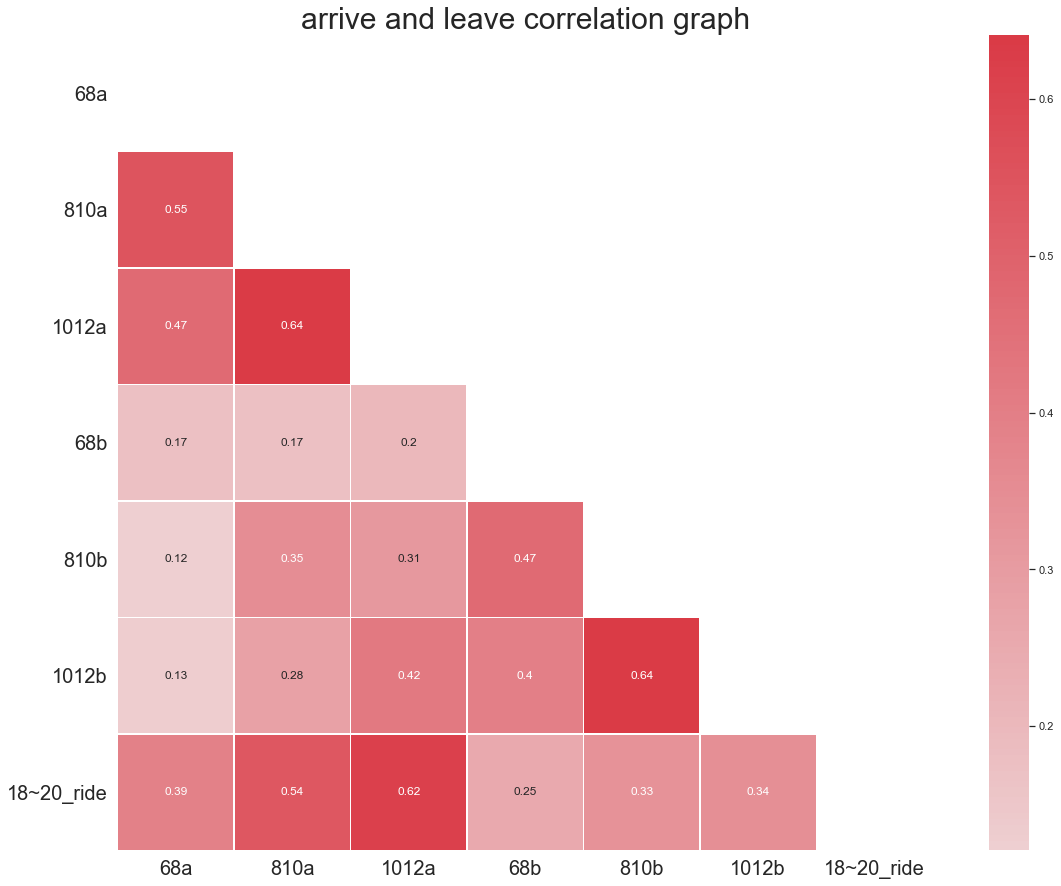

In [13]:
sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

In [14]:
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

# 4. 좌표 데이터를 이용한 Feature Engineering
## 4-1. 측정소 위치 및 정류장 위치 확인

In [15]:
# 해당 주요 장소의 임의 지역 위도, 경도

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

In [16]:
#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [17]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

In [ ]:
#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm

## 4-2. 측정소와 정류장 사이 거리 계산 적용


In [ ]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

In [ ]:
train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

In [ ]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )

In [ ]:
total.head()

In [ ]:
train['dist_name'] = total.apply(lambda x: x.argmin(),axis=1)

In [ ]:
data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

In [ ]:
Counter(data22['dist_name'])

In [ ]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

In [ ]:
train.head()

# 5. 외부 실제 측정 데이터 활용


In [ ]:
# https://data.kma.go.kr/cmmn/main.do
#데이터 불러오기
raining=pd.read_csv("/content/drive/MyDrive/YBIGTA/21-1 겨울방학/프로젝트/data/OBS_ASOS_TIM_20210114113345.csv",engine='python',encoding="cp949")

In [ ]:
raining.head()

In [ ]:
#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [ str(i) for i in raining['지점'] ]

raining['지점'] = ['0' if i=='184' else i for i in raining['지점'] ]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['1' if i=='185' else i for i in raining['지점'] ]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['2' if i=='188' else i for i in raining['지점'] ]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['3' if i=='189' else i for i in raining['지점'] ]  # 위도 : 33.24616 경도 : 126.5653

In [ ]:
raining.head()

In [ ]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 
raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 


In [ ]:
# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
rain2 = raining[ (raining['time']>12)  ]

In [ ]:

rain3 = rain2.groupby(['지점','일시'])[['기온(°C)','강수량(mm)']].mean()

rain3.to_csv("rain3.csv")

rain3=pd.read_csv("rain3.csv")

In [ ]:
# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})
rain3= rain3.fillna(0.00000)

In [ ]:
train.head()

In [ ]:
rain3.head()

In [ ]:
train2["dist_name"] = train2["dist_name"].apply(lambda x: int(x))
test2["dist_name"] = test2["dist_name"].apply(lambda x: int(x))

In [ ]:
train2=pd.merge(train,rain3,how='left',on=['dist_name','date'])
test2=pd.merge(test,rain3,how='left',on=['dist_name','date'])

In [ ]:
train2 = pd.get_dummies(train2,columns=['dist_name'])
test2 = pd.get_dummies(test2,columns=['dist_name'])

In [ ]:
train2.shape, test2.shape, train.shape, test.shape
((415423, 44), (228170, 43), (415423, 39), (228170, 38))

In [ ]:
train2.head()

# 6. randomforest을 활용한 모델링
## 6-1. 변수 선택 및 train data sampling


In [ ]:
train2.head()

In [ ]:
train2 = train2.rename(columns={"dist_name_0":"dist_name_jeju","dist_name_1":"dist_name_gosan","dist_name_2":"dist_name_seongsan","dist_name_3":"dist_name_po"})
test2 = test2.rename(columns={"dist_name_0":"dist_name_jeju","dist_name_1":"dist_name_gosan","dist_name_2":"dist_name_seongsan","dist_name_3":"dist_name_po"})

In [ ]:
train2

In [ ]:
input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
           'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','기온(°C)', '강수량(mm)', 
           'dist_name_gosan', 'dist_name_jeju','dist_name_po', 'dist_name_seongsan']

target=['18~20_ride']

In [ ]:
X_train=train2[input_var]
random.seed(1217) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)) )

In [ ]:
X_train=train2[input_var]
X_train=X_train.iloc[train_list,:]
y_train=train2[target]
y_train=y_train.iloc[train_list,:]

X_test=test2[input_var]

In [ ]:
X_train.shape, y_train.shape

## 6-2. Neural Networks

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model = Sequential()
model.add(Dense(128,input_dim=26,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(1))

In [ ]:
model.compile(loss="mse",optimizer='rmsprop')

In [ ]:
hist = model.fit(X_train, y_train, epochs=25,batch_size=64)

In [201]:
test['18~20_ride'] = model.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

In [202]:
test[['id','18~20_ride']].to_csv("/content/drive/MyDrive/YBIGTA/21-1 겨울방학/프로젝트/1. 버스 승차량 예측 프로젝트/DL/submission/submission_0115(1).csv",index=False)